In [1]:
import mitsuba as mi

mi.set_variant("cuda_ad_rgb")
import drjit as dr
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np

import os
import sys
ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

from utils.utils import image_to_bm, to_float, unidim_to_bm, rel_l1_loss, mse, LOSS_FNS, upsample, generate_rand_tex
from utils.plot import (
    plot_loss_linear_interp_1d,
    plot_loss_bilinear_interp_2d,
    plot_losses,
)
from utils.spot import reset_scene, TEX_KEY

mi.Thread.thread().logger().set_log_level(mi.LogLevel.Error)

In [11]:
def plot(
    images_bm, tex_bm, size_factor=3
):
    if not isinstance(images_bm, list):
        images_bm = [images_bm]
        tex_bm = [tex_bm]
    fig, ax = plt.subplots(
        ncols=2,
        nrows=len(images_bm),
        figsize=(8, size_factor * len(images_bm)),
        squeeze=False,
    )
    for i, (img, tex) in enumerate(
        zip(images_bm, tex_bm)
    ):
        ax[i, 0].imshow(img, vmin=0, vmax=1)
        ax[i, 1].imshow(tex, vmin=0, vmax=1)
        ax[i, 0].set_xticks([])
        ax[i, 0].set_yticks([])
        ax[i, 1].set_xticks([])
        ax[i, 1].set_yticks([])
    ax[0, 0].set_title("Rendering", weight="bold", size=14)
    ax[0, 1].set_title("Texture", weight="bold", size=14)
    plt.tight_layout()
    plt.show()

# Reference scenes rendering

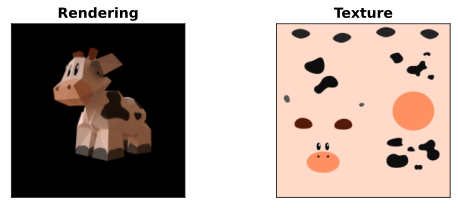

In [13]:
scene_ref = reset_scene()
params_ref = mi.traverse(scene_ref)

# Render reference images
image_ref = mi.render(scene_ref, seed=0, spp=1024)
plot(image_to_bm(image_ref), unidim_to_bm(params_ref[TEX_KEY]))

In [14]:
spp_primal = 128
spp = spp_primal
spp_grad = 32

In [15]:
# get reference losses
scene = reset_scene()
image = mi.render(scene, mi.traverse(scene), seed=0, spp=spp_primal, spp_grad=spp_grad)
ref_loss = {k: to_float(LOSS_FNS[k](image, image_ref)) for k in LOSS_FNS}
ref_loss

{'Relative L1': 0.012290137819945812, 'MSE': 4.007905226899311e-05}

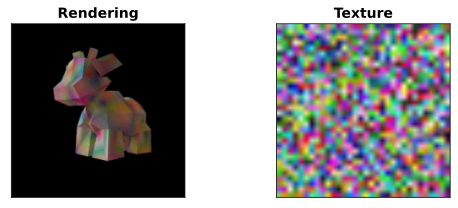

In [16]:
scene = reset_scene()
params = mi.traverse(scene)
params[TEX_KEY] = generate_rand_tex(init_res=(32, 32), opt_res=(1024, 1024), n_channels=3, seed=0)
params.update()
image = mi.render(scene, mi.traverse(scene), seed=0, spp=spp_primal, spp_grad=spp_grad)
plot(image_to_bm(image), unidim_to_bm(params[TEX_KEY]))

In [6]:
def run_opt_rand_init(
    upscaling_iter=[{"res": (32, 32), "n_iter": 50}],
    nb_opt_samples=1,
    optimizer_name="adam",
    lr=1e-2,
    loss_fn=mse,
    spp_primal=16,
    spp_grad=4,
    seed=0,
):
    # Optimization parameters
    optimizer_name = optimizer_name.lower().strip()

    losses = []
    images = []
    images_bm = []
    tex_bm = []
    params_end = []

    total_iter = sum([u["n_iter"] for u in upscaling_iter])

    for opt_sample in range(nb_opt_samples):
        losses.append([])
        images.append([])
        images_bm.append([])
        tex_bm.append([])
        params_end.append([])

        # Load scene
        scene = reset_scene()

        params = mi.traverse(scene)
        params[TEX_KEY] = generate_rand_tex(
            seed=seed + opt_sample,
            init_res=upscaling_iter[0]["res"],
            opt_res=upscaling_iter[0]["res"],
            n_channels=3,
        )
        params.update()

        if optimizer_name == "sgd":
            opt = mi.ad.optimizers.SGD(lr=lr)
        elif optimizer_name == "adam":
            opt = mi.ad.optimizers.Adam(lr=lr)
        else:
            raise ValueError(f"Unknown optimizer {optimizer_name}")

        opt[TEX_KEY] = params[TEX_KEY]
        params.update(opt)

        # initial rendering
        image = mi.render(
            scene,
            params,
            seed=seed + opt_sample,
            spp=spp_primal,
            spp_grad=spp_grad,
        )
        images[opt_sample].append(image)
        images_bm[opt_sample].append(image_to_bm(image))
        tex_bm[opt_sample].append(unidim_to_bm(params[TEX_KEY]))

        it = 1
        n_iter = 0
        for upscaling in upscaling_iter:
            params[TEX_KEY] = upsample(params[TEX_KEY], upscaling["res"])
            opt[TEX_KEY] = params[TEX_KEY]
            params.update(opt)

            n_iter += upscaling["n_iter"]
            while it <= n_iter:
                # Render
                image = mi.render(
                    scene,
                    params,
                    seed=seed + opt_sample * total_iter + it,
                    spp=spp_primal,
                    spp_grad=spp_grad,
                )

                # Apply loss function
                loss = loss_fn(image, image_ref)

                # Backpropagate
                dr.backward(loss)

                # Optimizer: take a gradient step
                opt.step()
                opt[TEX_KEY] = dr.clamp(opt[TEX_KEY], 1e-2, 1.0)

                # Optimizer: Update the scene parameters
                params.update(opt)

                if it == total_iter:
                    params_end[opt_sample].append(params[TEX_KEY])

                print(
                    f"[Sample {opt_sample+1}/{nb_opt_samples}] [res {upscaling['res']}]"
                    f" [iter {it - (n_iter - upscaling['n_iter'])}/{upscaling['n_iter']}] loss: {loss[0]:.5f}",
                    end="\r",
                )
                losses[opt_sample].append(loss[0])

                it += 1

            images[opt_sample].append(image)
            images_bm[opt_sample].append(image_to_bm(image))
            tex_bm[opt_sample].append(unidim_to_bm(params[TEX_KEY]))

            print()

    return {
        "losses": losses,
        "images": images,
        "images_bm": images_bm,
        "tex_bm": tex_bm,
        "params_end": params_end,
    }

# Upscaling

In [24]:
res = run_opt_rand_init(
    upscaling_iter=[{"res":128,"n_iter":50}, {"res":1024,"n_iter":50}],
    nb_opt_samples=1,
    optimizer_name="adam",
    lr=3e-2,
    loss_fn=mse,
    spp_primal=spp_primal,
    spp_grad=spp_grad,
)

[Sample 1/1] [res 128] [iter 50/50] loss: 0.00011
[Sample 1/1] [res 1024] [iter 50/50] loss: 0.00004


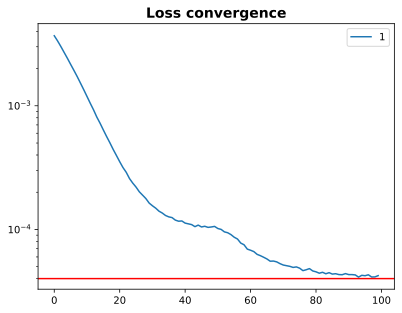

In [25]:
plot_losses(res["losses"], baseline=ref_loss["MSE"])

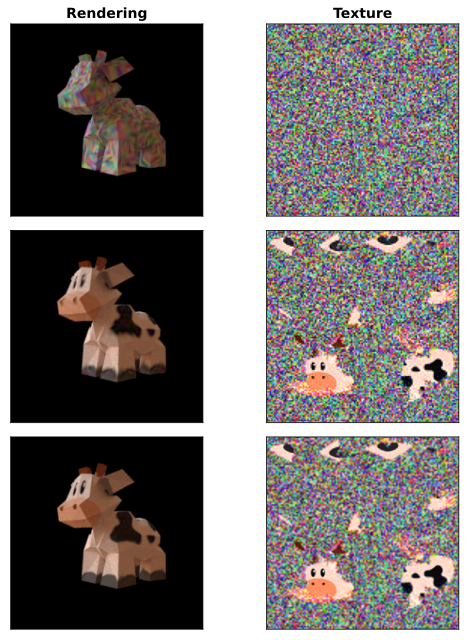

In [26]:
plot(res["images_bm"][0], res["tex_bm"][0], size_factor=3)

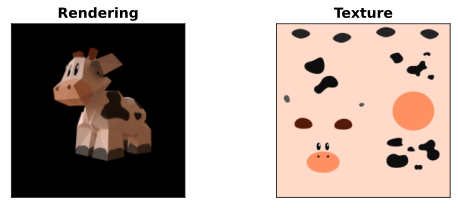

In [27]:
plot(image_to_bm(image_ref), unidim_to_bm(params_ref[TEX_KEY]))

# Without upscaling

In [32]:
res = run_opt_rand_init(
    upscaling_iter=[{"res":1024,"n_iter":100}],
    nb_opt_samples=1,
    optimizer_name="adam",
    lr=1e-1,
    loss_fn=mse,
    spp_primal=spp_primal,
    spp_grad=spp_grad,
)

[Sample 1/1] [res 1024] [iter 100/100] loss: 0.00005


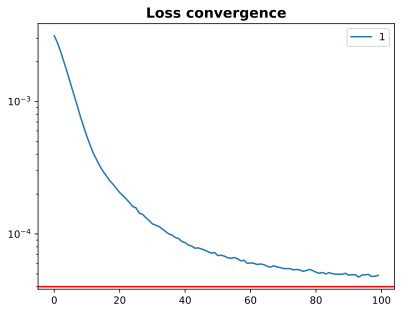

In [33]:
plot_losses(res["losses"], baseline=ref_loss["MSE"])

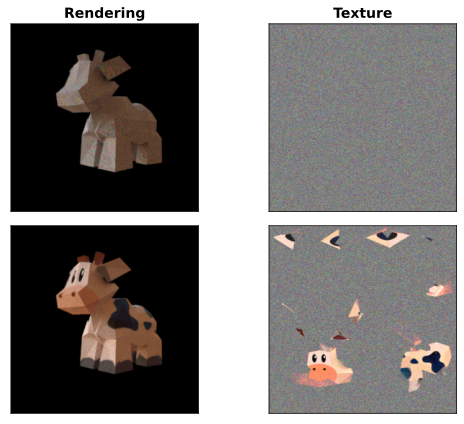

In [34]:
plot(res["images_bm"][0], res["tex_bm"][0], size_factor=3)